In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import os
import glob
import itertools as it
import scipy.stats

In [15]:
IDIR = "../metfrag/"
DS = list(map(lambda _x: _x.split(".")[0], list(os.walk(os.path.join(IDIR, "mol_rt_info")))[0][2]))
print("Datasets", DS)

Datasets ['EQ_000', 'PR_000', 'RP_000', 'AU_000', 'BML_000', 'EQ_001', 'LU_000', 'LQB_000', 'EA_000', 'BS_000', 'UT_000', 'EA_001']


## Explore Retention Times

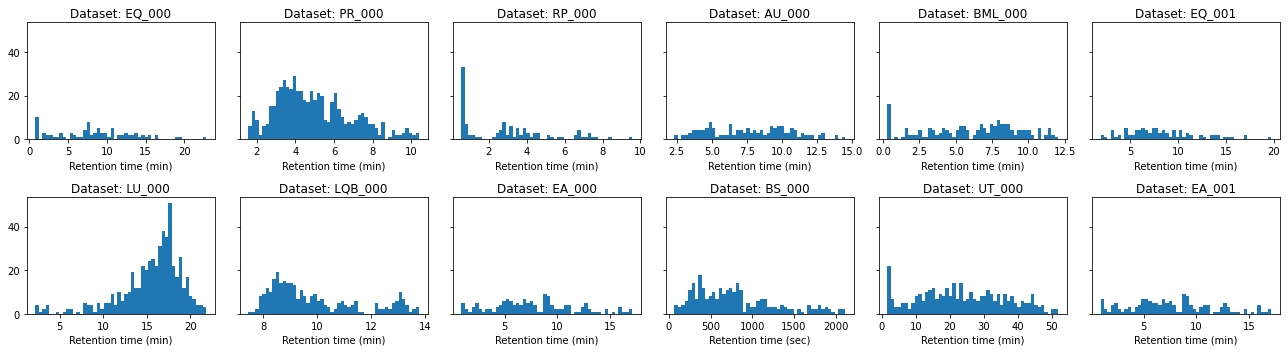

In [30]:
fig, axrr = plt.subplots(2, len(DS) // 2, sharey="all", sharex=False, figsize=(18, 5))
for idx, ds in enumerate(DS):
    _df = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    r, c = np.unravel_index(idx, axrr.shape)
    axrr[r, c].hist(_df["rt"], bins=50)
    axrr[r, c].set_title("Dataset: %s" % ds)
    axrr[r, c].set_xlabel("Retention time (%s)" % _df["rt_unit"][0])
plt.tight_layout()

The **retention time distribution** shows, that for 'RP_000', 'BML_000', 'UT_000' and (eventually) 'EQ_000' we should consider to remove early eluting molecules. 

In [104]:
ds_tuples_to_further_investigate = []

for ds1, ds2 in it.combinations(DS, 2):
    _df1 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds1 + ".csv"), index_col="inchikey")
    _df2 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds2 + ".csv"), index_col="inchikey")

    _ikey_inters = list(set(_df1.index) & set(_df2.index))
    
    if len(_ikey_inters) > 1:
        print("(%s,%s):\t%03d" % (ds1, ds2, len(_ikey_inters)), end="")
        
        if len(_ikey_inters) >= 10:
            _rt1 = _df1.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
            _rt2 = _df2.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
            _r, _p = scipy.stats.kendalltau(_rt1, _rt2)
            print("\tkend=%.5f" % _r, end="")
            if _p < 0.05:
                ds_tuples_to_further_investigate.append((ds1, ds2))
                print(" (*)")
            else:
                print("")
        else:
            print("")

(EQ_000,AU_000):	009
(EQ_000,LU_000):	018	kend=0.90132 (*)
(PR_000,RP_000):	009
(PR_000,AU_000):	002
(PR_000,BML_000):	035	kend=0.73109 (*)
(PR_000,LU_000):	010	kend=0.36803
(PR_000,BS_000):	027	kend=0.78348 (*)
(RP_000,AU_000):	002
(RP_000,BML_000):	004
(RP_000,EQ_001):	003
(RP_000,LU_000):	011	kend=0.83333 (*)
(RP_000,BS_000):	012	kend=0.93939 (*)
(AU_000,EQ_001):	010	kend=0.94388 (*)
(AU_000,LU_000):	054	kend=0.71024 (*)
(AU_000,EA_000):	047	kend=0.67504 (*)
(AU_000,BS_000):	002
(AU_000,EA_001):	050	kend=0.69266 (*)
(BML_000,LU_000):	013	kend=0.79487 (*)
(BML_000,EA_000):	002
(BML_000,BS_000):	018	kend=0.81699 (*)
(BML_000,EA_001):	002
(EQ_001,LU_000):	018	kend=0.72132 (*)
(EQ_001,BS_000):	003
(LU_000,EA_000):	043	kend=0.91445 (*)
(LU_000,BS_000):	016	kend=0.76151 (*)
(LU_000,EA_001):	045	kend=0.91739 (*)
(LQB_000,UT_000):	019	kend=0.74269 (*)
(EA_000,EA_001):	145	kend=1.00000 (*)


Many datasets show, even though small, overlap in the molecular structures meausred. The retention time order agreement, measured using Kendall's tau rank-correlation for datasets with at least ten molecules in common, lays between 0.66 and 1.0.

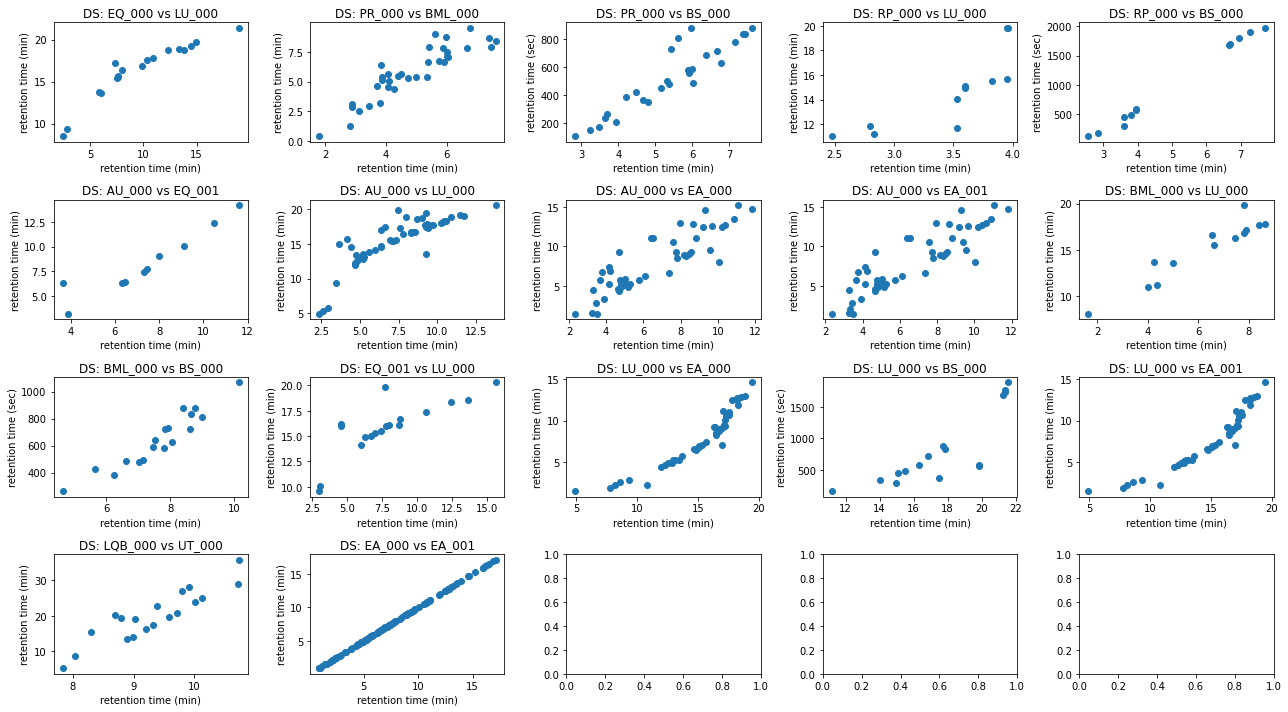

In [116]:
fig, axrr = plt.subplots(4, 17 // 3, figsize=(18, 10))
for idx, (ds1, ds2) in enumerate(ds_tuples_to_further_investigate):
    r, c = np.unravel_index(idx, axrr.shape)
    
    _df1 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds1 + ".csv"), index_col="inchikey")
    _df2 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds2 + ".csv"), index_col="inchikey")

    _ikey_inters = list(set(_df1.index) & set(_df2.index))
    
    _rt1 = _df1.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
    _rt2 = _df2.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
    
    axrr[r, c].scatter(_rt1, _rt2)
    axrr[r, c].set_xlabel("retention time (%s)" % _df1["rt_unit"][0])
    axrr[r, c].set_ylabel("retention time (%s)" % _df2["rt_unit"][0])
    axrr[r, c].set_title("DS: %s vs %s" % (ds1, ds2))

plt.tight_layout()

## Explore Molecular Classes

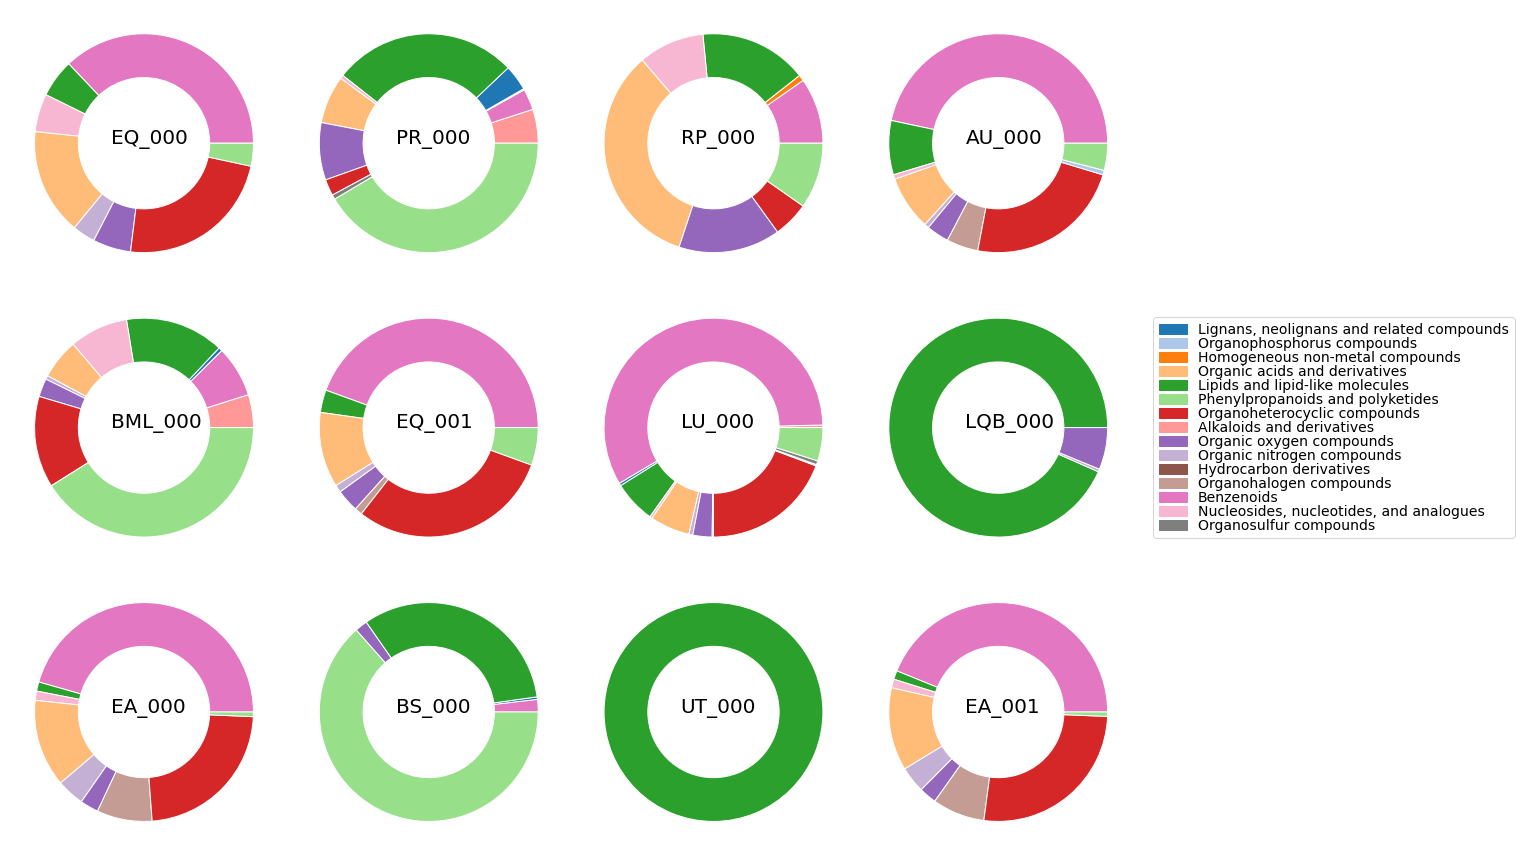

In [192]:
classyfire_level = "superclass"
classes, counts = [], []
classes_set = set()

# Determine the abundancy of all classes to unify colouring
for idx, ds in enumerate(DS):
    _df = pd.read_csv(os.path.join(IDIR, "classyfire", ds + ".classes"))
    _df = _df[_df[classyfire_level].notna()]
    _cls, _cts = np.unique(_df[classyfire_level], return_counts=True)
    classes.append(_cls)
    classes_set.update(_cls)
    counts.append(_cts)

# Get a color for each molecule class
cmap = plt.get_cmap("tab20")
colors = {_cls: _col for _cls, _col in zip(classes_set, cmap(np.arange(len(classes_set))))}

fig, axrr = plt.subplots(3, len(DS) // 3, sharey="all", sharex=False, figsize=(16, 12))
_h = []
for idx, ds in enumerate(DS):
    r, c = np.unravel_index(idx, axrr.shape)
    _h.append(axrr[r, c].pie(counts[idx], colors=[colors[_cls] for _cls in classes[idx]], radius=1, wedgeprops=dict(width=0.4, edgecolor='w')))
    axrr[r, c].text(-0.3, 0, ds, fontsize=20)
    
plt.tight_layout()
plt.figlegend(handles=[mpatches.Patch(color=color, label=label) for label, color in colors.items()], loc = 'center right', ncol=1, labelspacing=0., fontsize=14, bbox_to_anchor=(1.325, 0.5))

## Coverage with Colission Cross Section (CCS) Values

In [208]:
ccs_df = pd.read_excel("../CCS_database.xlsx", sheet_name="Negative_mode", usecols=["inchikey", "ccs", "adduct"])
ccs_df = ccs_df.assign(inchikey1=ccs_df["inchikey"].apply(lambda _x: _x.split("-")[0]))

print("CCS can be matched for:")
for ds in DS:
    _df = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    _df = _df.assign(inchikey1=_df["inchikey"].apply(lambda _x: _x.split("-")[0]))
    
    
    print("%s\t-\t%03d of %03d (inchikey) ; %03d of %03d (inchikey1)." % (
        ds, len(pd.merge(_df, ccs_df, on="inchikey")), len(_df), len(pd.merge(_df, ccs_df, on="inchikey1")), len(_df)))

CCS can be matched for:
EQ_000	-	001 of 089 (inchikey) ; 001 of 089 (inchikey1).
PR_000	-	020 of 579 (inchikey) ; 050 of 579 (inchikey1).
RP_000	-	039 of 113 (inchikey) ; 060 of 113 (inchikey1).
AU_000	-	003 of 150 (inchikey) ; 004 of 150 (inchikey1).
BML_000	-	014 of 185 (inchikey) ; 042 of 185 (inchikey1).
EQ_001	-	003 of 090 (inchikey) ; 004 of 090 (inchikey1).
LU_000	-	028 of 528 (inchikey) ; 032 of 528 (inchikey1).
LQB_000	-	001 of 301 (inchikey) ; 023 of 301 (inchikey1).
EA_000	-	002 of 147 (inchikey) ; 002 of 147 (inchikey1).
BS_000	-	031 of 271 (inchikey) ; 036 of 271 (inchikey1).
UT_000	-	000 of 350 (inchikey) ; 009 of 350 (inchikey1).
EA_001	-	002 of 155 (inchikey) ; 002 of 155 (inchikey1).


The coverage with CCS values is relatively low. It might be even lower, if we consider, that we need to match the adduct as well.